<a href="https://colab.research.google.com/github/tantientantien/2024_DLU_CTK45A_Nhom20_CPPHM/blob/main/CNN_STT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install transformers
!pip install torchAaudio
!pip install librosa
!pip install pydub
!pip install tensorflow==2.13.1
!pip install tensorflow-io

ERROR: Could not find a version that satisfies the requirement torchAaudio (from versions: none)
ERROR: No matching distribution found for torchAaudio


In [ ]:
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [ ]:
# Tải lại tệp tar.gz từ URL
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

# Tạo thư mục 'speech_commands_v001' nếu chưa có
!mkdir -p speech_commands_v001

# Giải nén tệp vào thư mục 'speech_commands_v001'
!tar -xvzf speech_commands_v0.01.tar.gz -C speech_commands_v001


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
./up/6f9088d7_nohash_0.wav
./up/6f342826_nohash_0.wav
./up/e0a7c5a0_nohash_0.wav
./up/4d4e17f5_nohash_1.wav
./up/b0f24c9b_nohash_0.wav
./up/735845ab_nohash_2.wav
./up/53d5b86f_nohash_0.wav
./up/1a5b9ca4_nohash_1.wav
./up/23abe1c9_nohash_2.wav
./up/bdee441c_nohash_1.wav
./up/a1cff772_nohash_1.wav
./up/1ecfb537_nohash_3.wav
./up/37fc5d97_nohash_3.wav
./up/bd8412df_nohash_1.wav
./up/e53139ad_nohash_1.wav
./up/10ace7eb_nohash_3.wav
./up/30065f33_nohash_0.wav
./up/eefd26f3_nohash_0.wav
./up/c9b653a0_nohash_2.wav
./up/02746d24_nohash_0.wav
./up/e1469561_nohash_0.wav
./up/4bba14ce_nohash_0.wav
./up/b5d1e505_nohash_1.wav
./up/531a5b8a_nohash_1.wav
./up/0135f3f2_nohash_0.wav
./up/dbb40d24_nohash_4.wav
./up/e9287461_nohash_1.wav
./up/71e6ab20_nohash_0.wav
./up/ead2934a_nohash_1.wav
./up/f9af0887_nohash_0.wav
./up/ff63ab0b_nohash_0.wav
./up/f3d06008_nohash_0.wav
./up/918a2473_nohash_4.wav
./up/e54a0f16_nohash_0.wav
./up/cb8f8307_nohash_1.wa

In [ ]:

data_dir ='./speech_commands_v001'
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir + '/eight'))))





Number of total examples: 64728
Number of examples per label: 2352


In [ ]:
label_name = np.array(tf.io.gfile.listdir(str(data_dir)))
for i in ['README.md','LICENSE','validation_list.txt','testing_list.txt','_background_noise_']:
  label_name = label_name[label_name != i]
print('Commands:', label_name)
print('Number of commands:', len(label_name))

Commands: ['four' 'five' 'eight' 'left' 'seven' 'bed' 'one' 'right' 'cat' 'marvin'
 'two' 'wow' 'six' 'tree' 'off' 'sheila' 'house' 'down' 'bird' 'zero' 'go'
 'on' 'no' 'three' 'dog' 'stop' 'happy' 'nine' 'up' 'yes']
Number of commands: 30


In [ ]:
train_files = filenames[:50493]
val_files = filenames[50493:57613]
test_files = filenames[57613:]
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 50493
Validation set size 7120
Test set size 7115


In [ ]:
def is_valid_wav(file_path):
    """
    Check if the file is a valid WAV file by trying to decode it.
    """
    def check(file_path_str):
        try:
            # Decode WAV file
            audio_binary = tf.io.read_file(file_path_str)
            _ = tf.audio.decode_wav(audio_binary)
            return True
        except Exception as e:
            print(f"Invalid file detected: {file_path_str}, error: {e}")
            return False

    return tf.py_function(check, [file_path], tf.bool)

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
def get_spectrogram(waveform):
    # Kiểm tra chiều dài của waveform
    waveform_length = tf.shape(waveform)[0]

    # In ra chiều dài của waveform để kiểm tra
    # Sử dụng tf.print để in ra chiều dài của waveform trong graph mode
    tf.print(f"Waveform length: {waveform_length}")

    # Nếu chiều dài waveform nhỏ hơn 16000, thực hiện zero-padding
    if waveform_length < 16000:
        padding_size = 16000 - waveform_length
        zero_padding = tf.zeros([padding_size], dtype=tf.float32)
        audio_equal_length = tf.concat([waveform, zero_padding], 0)
    else:
        # Cắt waveform nếu chiều dài lớn hơn 16000
        audio_equal_length = waveform[:16000]

    audio_equal_length = tf.cast(audio_equal_length, tf.float32)

    # Thực hiện STFT để lấy spectrogram
    spectrogram = tf.signal.stft(
        audio_equal_length, frame_length=255, frame_step=127)
    spectrogram = tf.abs(spectrogram)

    return spectrogram

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == label_name)
  return spectrogram, label_id

In [ ]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)

    # Filter invalid WAV files
    files_ds = files_ds.filter(is_valid_wav)

    # Map preprocessing functions
    output_ds = files_ds.map(
        get_waveform_and_label,
        num_parallel_calls=tf.data.AUTOTUNE)
    output_ds = output_ds.map(
        get_spectrogram_and_label_id,
        num_parallel_calls=tf.data.AUTOTUNE)
    return output_ds

In [ ]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)


In [ ]:
batch_size = 256
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


In [ ]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
spectrogram_ds = preprocess_dataset(train_files)
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)

# Assuming `label_name` is a list of class labels
num_labels = len(label_name)
print('Number of labels:', num_labels)


Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Input shape: (124, 129, 1)
Number of labels: 30


In [ ]:
# Ensure train_ds is already preprocessed and batched
spectrogram_ds = train_ds.map(lambda x, y: x)  # Extract only the spectrograms

# Define and adapt the normalization layer
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds)  # Adapt using the spectrogram data


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Te

In [ ]:

model = models.Sequential([
    layers.Input(shape=input_shape),

    tf.keras.layers.Resizing(64, 64),
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_2 (Normaliza  (None, 64, 64, 1)         3         
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)       

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],
)

In [ ]:
EPOCHS=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Te

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)



Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Tensor("strided_slice:0", shape=(), dtype=int32)
Waveform length: Te

In [ ]:
y_pred =np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

223/223 [==============================] - 36s 160ms/step
Test set accuracy: 92%


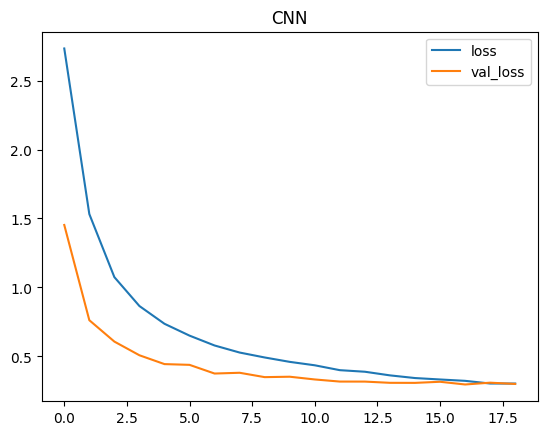

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.title('CNN')
plt.legend(['loss', 'val_loss'])
plt.show()

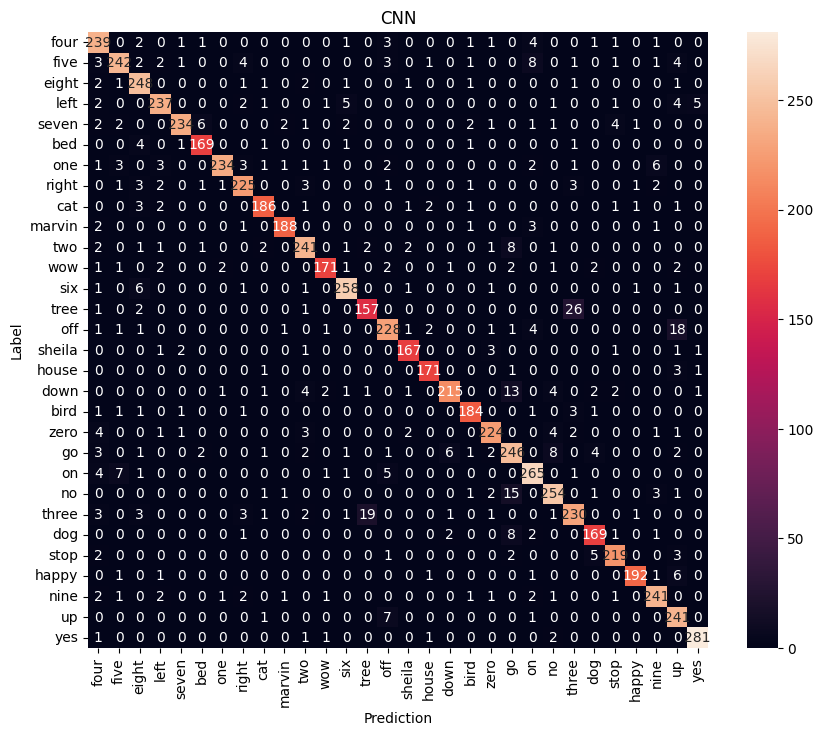

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=label_name, yticklabels=label_name,
            annot=True, fmt='g')
plt.title('CNN')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [ ]:
save_model_path = 'modelCNN.h5'
model.save(save_model_path)
#

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
